# **Keras 예제 - Seq2Seq 로 덧셈/곱셈 구현**

출처
- RNN 덧셈 예제 : https://github.com/keras-team/keras/blob/2.0.0/examples/addition_rnn.py
- 사칙연산 예제 : https://towardsdatascience.com/making-rnn-model-learn-arithmetic-operations-b016ec4d8388
- 텐서플로우 버전 : 2.6



In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# -*- coding: utf-8 -*-
'''An implementation of sequence to sequence learning for performing addition
Input: "535+61"
Output: "596"
Padding is handled by using a repeated sentinel character (space)
Input may optionally be inverted, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.
Two digits inverted:
+ One layer LSTM (128 HN), 5k training examples = 99% train/test accuracy in 55 epochs
Three digits inverted:
+ One layer LSTM (128 HN), 50k training examples = 99% train/test accuracy in 100 epochs
Four digits inverted:
+ One layer LSTM (128 HN), 400k training examples = 99% train/test accuracy in 20 epochs
Five digits inverted:
+ One layer LSTM (128 HN), 550k training examples = 99% train/test accuracy in 30 epochs
'''

'An implementation of sequence to sequence learning for performing addition\nInput: "535+61"\nOutput: "596"\nPadding is handled by using a repeated sentinel character (space)\nInput may optionally be inverted, shown to increase performance in many tasks in:\n"Learning to Execute"\nhttp://arxiv.org/abs/1410.4615\nand\n"Sequence to Sequence Learning with Neural Networks"\nhttp://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf\nTheoretically it introduces shorter term dependencies between source and target.\nTwo digits inverted:\n+ One layer LSTM (128 HN), 5k training examples = 99% train/test accuracy in 55 epochs\nThree digits inverted:\n+ One layer LSTM (128 HN), 50k training examples = 99% train/test accuracy in 100 epochs\nFour digits inverted:\n+ One layer LSTM (128 HN), 400k training examples = 99% train/test accuracy in 20 epochs\nFive digits inverted:\n+ One layer LSTM (128 HN), 550k training examples = 99% train/test accuracy in 30 epochs\n'

In [3]:
from __future__ import print_function
from keras.models import Sequential
from keras import layers
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers
import numpy as np
from six.moves import range
import matplotlib.pyplot as plt
import sys

Using TensorFlow backend.


In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
#tf.config.list_physical_devices('GPU')

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5394902383071992762,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17953452153211022111
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10987565876
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14599384750341754748
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1",
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10987565876
 locality {
   bus_id: 2
   numa_node: 1
   links {
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 4
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 17288025301456199266
 physical_dev

In [5]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="2,3,4"

In [6]:
class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    # 초기화 : 사용되는 문자 집합이 주어지면 caharacter table 을 초기화한다.
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        # 문자 집합이 주어지면 각 문자에 대한 인덱스를 매긴다.
        # char_indices : (문자, 인덱스), indices_char : (인덱스, 문자)
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        print('char_indices:',  self.char_indices)
        print('indeces_char: ', self.indices_char)

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        # 문장(C)의 문자에 해당하는 행렬 위치를 0->1 로 바꾼다.
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1    # 순서대로 i번째 행에 char_indices[c] 열에 1 대입
        return x

    def decode(self, x, calc_argmax=True):
        # print('decode 할 x: ', x)
        if calc_argmax:
            x = x.argmax(axis=-1) # decode 할 x가 들어오면, 
            # print('x.argmax: ', x)
        return ''.join(self.indices_char[x] for x in x)

In [7]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [8]:
def weird_division(n, d):
    return n / d if d else 0

In [9]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
INVERT = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAxLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
# ctable : 문자 집합에 대해 character table 을 만든 인스턴스(?)
chars = '0123456789+* '
calc = '+*'
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
file_path = './dataset/3digit_plusmul.txt'

print('Get data...from txt')
for line in open(file_path, 'r'):
        idx = line.find('_')
        questions.append(line[:idx][::-1])
        expected.append(line[idx+1:-1])

# Generating Data...
# np.random.randint(1, 20) : 1~19까지 랜덤한 숫자 1개
# while len(questions) < TRAINING_SIZE:   #50000개 만듦
#     # f : 최대 3자리까지 랜덤한 숫자를 만든다.
#     f = lambda: int(''.join(np.random.choice(list('0123456789'))
#                     for i in range(np.random.randint(1, DIGITS + 1))))
#     a, b = f(), f()

#     # Skip any addition questions we've already seen
#     # Also skip any such that x+Y == Y+x (hence the sorting).
#     key = tuple(sorted((a, b)))
#     if key in seen:
#         continue
#     seen.add(key)

#     # Pad the data with spaces such that it is always MAxLEN.
#     q = str(a) + np.random.choice(list(calc)) + str(b)
#     # q = '{}+{}'.format(a, b)
#     query = q + ' ' * (MAxLEN - len(q)) # 전체 길이 - q 길이 만큼 padding 을 줘서 전체 길이가 맞춰지도록.
#     if '+' in q:
#       ans = str(a + b)
#     else:
#       ans = str(a * b)
  
#     # Answers can be of maximum size DIGITS + 1.
#     # answer 도 패딩을 맞춰준다. (answer가 될 수 있는 최대 길이에서 - 현재 나온 답의 길이 만큼)
#     # answer 의 최대 길이 : 6자리(999*999 = 998001)
#     ans += ' ' * (DIGITS + 3 - len(ans))

#     # Input의 Reverse 여부
#     if INVERT:
#         # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
#         # space used for padding.)
#         query = query[::-1] # Reverse
#     questions.append(query)
#     expected.append(ans)
# print('Total addition questions:', len(questions))


char_indices: {' ': 0, '*': 1, '+': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12}
indeces_char:  {0: ' ', 1: '*', 2: '+', 3: '0', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6', 10: '7', 11: '8', 12: '9'}
Get data...from txt


In [10]:
# Reverse 해서 인풋이 거꾸로 출력됨.
print(questions[1] + '?' + expected[1])
print(questions[1][::-1])
print(expected[1])
print(expected[1] + '?')

  9*084?4320  
480*9  
4320  
4320  ?


In [11]:
# f = open('plusmul.txt', 'w')
# for i in range(len(questions)):
# #     data = questions[i][::-1] + '_' + expected[i] + '\n'
#     data = questions[i] + '_' + expected[i] + '\n'
#     f.write(data)
# f.close()


In [12]:
# print('Vectorization...')
# # np.zeros(shape, dtype, order)
# x = np.zeros((len(questions), MAxLEN, len(chars)), dtype=np.bool)
# y = np.zeros((len(questions), DIGITS + 3, len(chars)), dtype=np.bool)
# print(x.shape)
# print(y.shape)

In [13]:
print('Vectorization...')
# np.zeros(shape, dtype, order)
# x : (50000, 7, 15), y : (50000, 6, 15)
# 입력데이터를 Encode
# 일단 x, y 를 0으로 초기화
x = np.zeros((len(questions), MAxLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 3, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAxLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 3)

# print('x[1]: ', x[1])
# print('y[1]: ', y[1])

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
# x의 뒷부분이 더 커지기 때문에 (x, y) 를 섞는다. (???) -> 어쨋든 셔플
# x[indices] : 50,000개의 데이터가 셔플 되는 것 같음
# indices = np.arange(len(y))
# np.random.shuffle(indices)
# x = x[indices]
# y = y[indices]

# print('shuffle x: ', x)
# print('shuffle y: ', y)

# Explicitly set apart 10% for validation data that we never train over.
# Test Set : 0~45000, Validation Set : 45000~50000
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Vectorization...
Training Data:
(45000, 7, 13)
(45000, 6, 13)
Validation Data:
(5000, 7, 13)
(5000, 6, 13)


In [14]:
# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()

# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAxLEN, len(chars))))

# As the decoder RNN's input, repeatedly provide with the last hidden state of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 3))

# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    # return_sequences(시퀀스 출력 여부): True(각 시퀀스에서 출력, many-to-many 일 때)
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
# TimeDistributed :7개의 시간 단계 각각에 독립적으로 Dense 레이어를 적용
model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72704     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 6, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 6, 13)             1677      
_________________________________________________________________
activation_1 (Activation)    (None, 6, 13)             0         
Total params: 205,965
Trainable params: 205,965
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Train the model each generation and show predictions against the validation
# dataset.
acc_list = []
valacc_list = []
trainacc_list = []
val_loss_list = []
train_loss_list = []

for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, verbose = 1, epochs=1,
              validation_data=(x_val, y_val))
    # Select samples from the validation set at random so we can visualize
    # errors.
    valacc_list.append(history.history.get('val_accuracy')[0])
    trainacc_list.append(history.history.get('accuracy')[0])
    val_loss_list.append(history.history.get('val_loss')[0])
    train_loss_list.append(history.history.get('loss')[0])
        
    correct_num = 0
    # sys.stdout = open('output.txt','w')
    for i in range(len(x_val)):
        rowx, rowy = x_val[np.array([i])], y_val[np.array([i])]

        # predict_classes : 0 or 1로 출력 (predict 와 약간 다름) --> 2.6버전에서 삭제됨
        # 모델이 예측(확률로 출력)
        predict_x=model.predict(rowx) 
        # (axis: 0->x축, 1-> y축, 2-> z축) -> 중요
        classes_x=np.argmax(predict_x,axis=2)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(classes_x[0], calc_argmax=False)
        
#        print('guess: ', guess)
#        print('Q', q[::-1] if INVERT else q)
#        print('T', correct)
        if correct == guess:
            # print(colors.ok + '☑' + colors.close, end=" ")
            correct_num += 1
        else:
            # print(colors.fail + '☒' + colors.close, end=" ")
            correct_num += 0
        # print(guess)
#        print('---')
    acc = float(correct_num) / len(x_val)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))
    if iteration == 100:
      print('100번째 정확도 : ', acc)
model.save('./model/plusmul.h5')


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 9s 200us/step - loss: 1.6191 - accuracy: 0.4264 - val_loss: 1.5980 - val_accuracy: 0.4150
검증 정확도 0.000%

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 7s 166us/step - loss: 1.4893 - accuracy: 0.4542 - val_loss: 1.5582 - val_accuracy: 0.4212
검증 정확도 0.000%

--------------------------------------------------
Iteration 3
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 8s 169us/step - loss: 1.4532 - accuracy: 0.4610 - val_loss: 1.5365 - val_accuracy: 0.4267
검증 정확도 0.040%

--------------------------------------------------
Iteration 4
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 7s 164us

45000/45000 [==============================] - 8s 167us/step - loss: 0.4944 - accuracy: 0.8214 - val_loss: 0.6248 - val_accuracy: 0.7670
검증 정확도 38.640%

--------------------------------------------------
Iteration 31
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 7s 165us/step - loss: 0.4862 - accuracy: 0.8242 - val_loss: 0.6140 - val_accuracy: 0.7669
검증 정확도 39.060%

--------------------------------------------------
Iteration 32
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 8s 171us/step - loss: 0.4815 - accuracy: 0.8246 - val_loss: 0.5970 - val_accuracy: 0.7792
검증 정확도 44.960%

--------------------------------------------------
Iteration 33
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 8s 168us/step - loss: 0.4669 - accuracy: 0.8312 - val_loss: 0.5849 - val_accuracy: 0.7836
검증 정확도 44.920%

-------------------

45000/45000 [==============================] - 8s 173us/step - loss: 0.3433 - accuracy: 0.8747 - val_loss: 0.5262 - val_accuracy: 0.8068
검증 정확도 49.440%

--------------------------------------------------
Iteration 61
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 8s 172us/step - loss: 0.3310 - accuracy: 0.8795 - val_loss: 0.5056 - val_accuracy: 0.8109
검증 정확도 50.060%

--------------------------------------------------
Iteration 62
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 8s 169us/step - loss: 0.3279 - accuracy: 0.8801 - val_loss: 0.5402 - val_accuracy: 0.8002
검증 정확도 47.600%

--------------------------------------------------
Iteration 63
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 8s 175us/step - loss: 0.3291 - accuracy: 0.8795 - val_loss: 0.5102 - val_accuracy: 0.8095
검증 정확도 49.920%

-------------------

45000/45000 [==============================] - 8s 167us/step - loss: 0.2607 - accuracy: 0.9075 - val_loss: 0.5584 - val_accuracy: 0.8099
검증 정확도 49.100%

--------------------------------------------------
Iteration 91
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 8s 171us/step - loss: 0.2488 - accuracy: 0.9122 - val_loss: 0.5537 - val_accuracy: 0.8106
검증 정확도 50.480%

--------------------------------------------------
Iteration 92
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 8s 169us/step - loss: 0.2428 - accuracy: 0.9142 - val_loss: 0.5572 - val_accuracy: 0.8095
검증 정확도 50.340%

--------------------------------------------------
Iteration 93
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 7s 167us/step - loss: 0.2456 - accuracy: 0.9129 - val_loss: 0.5635 - val_accuracy: 0.8107
검증 정확도 50.360%

-------------------

45000/45000 [==============================] - 7s 166us/step - loss: 0.1787 - accuracy: 0.9400 - val_loss: 0.6653 - val_accuracy: 0.8085
검증 정확도 50.320%

--------------------------------------------------
Iteration 121
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 8s 169us/step - loss: 0.1737 - accuracy: 0.9426 - val_loss: 0.6775 - val_accuracy: 0.8069
검증 정확도 49.700%

--------------------------------------------------
Iteration 122
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 8s 167us/step - loss: 0.1753 - accuracy: 0.9411 - val_loss: 0.6985 - val_accuracy: 0.8042
검증 정확도 48.700%

--------------------------------------------------
Iteration 123
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 8s 176us/step - loss: 0.1737 - accuracy: 0.9427 - val_loss: 0.6902 - val_accuracy: 0.8043
검증 정확도 49.420%

----------------

45000/45000 [==============================] - 8s 167us/step - loss: 0.1144 - accuracy: 0.9657 - val_loss: 0.8249 - val_accuracy: 0.8041
검증 정확도 49.720%

--------------------------------------------------
Iteration 151
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 7s 167us/step - loss: 0.1461 - accuracy: 0.9535 - val_loss: 0.8507 - val_accuracy: 0.7985
검증 정확도 47.560%

--------------------------------------------------
Iteration 152
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 8s 167us/step - loss: 0.1170 - accuracy: 0.9642 - val_loss: 0.8464 - val_accuracy: 0.8022
검증 정확도 49.520%

--------------------------------------------------
Iteration 153
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 8s 167us/step - loss: 0.1069 - accuracy: 0.9691 - val_loss: 0.8412 - val_accuracy: 0.8048
검증 정확도 49.700%

----------------

45000/45000 [==============================] - 8s 181us/step - loss: 0.0721 - accuracy: 0.9813 - val_loss: 1.0116 - val_accuracy: 0.7973
검증 정확도 48.940%

--------------------------------------------------
Iteration 181
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 8s 170us/step - loss: 0.0754 - accuracy: 0.9799 - val_loss: 1.0264 - val_accuracy: 0.7947
검증 정확도 47.240%

--------------------------------------------------
Iteration 182
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 7s 166us/step - loss: 0.0809 - accuracy: 0.9771 - val_loss: 1.0464 - val_accuracy: 0.7965
검증 정확도 48.920%

--------------------------------------------------
Iteration 183
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 7s 167us/step - loss: 0.1019 - accuracy: 0.9686 - val_loss: 1.0322 - val_accuracy: 0.7938
검증 정확도 47.700%

----------------

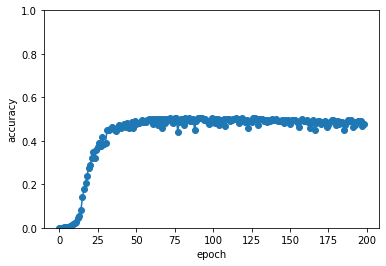

In [16]:
# train loss 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

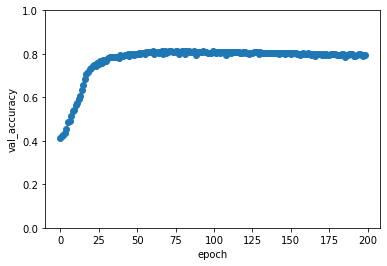

In [17]:
# validation accuracy 그래프 그리기
v = np.arange(len(valacc_list))
plt.plot(v, valacc_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('val_accuracy')
plt.ylim(0, 1.0)
plt.show()

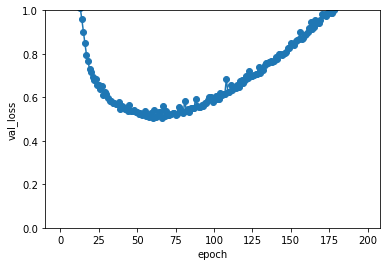

In [18]:
# validation loss 그래프 그리기
v = np.arange(len(val_loss_list))
plt.plot(v, val_loss_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.ylim(0, 1.0)
plt.show()

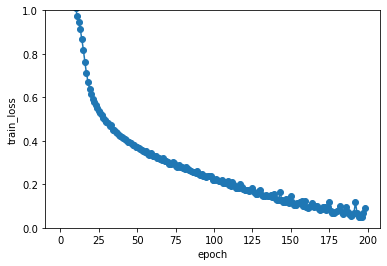

In [19]:
# train loss 그래프 그리기
v = np.arange(len(train_loss_list))
plt.plot(v, train_loss_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.ylim(0, 1.0)
plt.show()

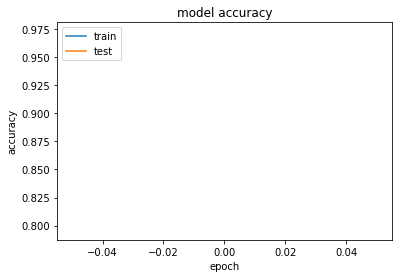

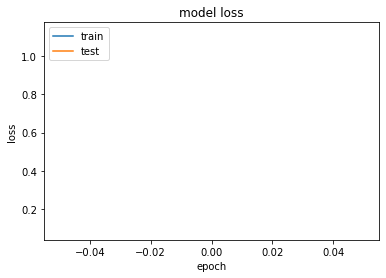

In [20]:
## summarize history for accuracy
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
# Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).